In [1]:
import sys
sys.path.append("../") # go to parent dir
%load_ext autoreload
%autoreload 2

In [2]:
import xgboost as xgb

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.metrics import mean_squared_error

In [4]:
def compare_sets(set1, set2):
    union = set1.union(set2)
    set_1_unique = set1.difference(set2)
    set_2_unique = set2.difference(set1)
    
    print(f"set 1 size: {len(set1)}")
    print(f"set 2 size: {len(set2)}")
    print(f"Union size: {len(union)}")
    print(f"set 1 unique elements: {len(set_1_unique)}")
    print(f"set 2 unique elements: {len(set_2_unique)}")
    return

### Import data

In [5]:
item_categories = pd.read_csv('../data/item_categories.csv')
items = pd.read_csv("../data/items.csv")
sales_train = pd.read_csv("../data/sales_train.csv")
shops = pd.read_csv("../data/shops.csv")
test = pd.read_csv("../data/test.csv")
sample_subm = pd.read_csv('../data/sample_submission.csv')

In [6]:
# Nov 2015
test['date_block_num'] = 34

In [7]:
# Seems useless - item_name -> item_id, item_category_id mappings are already inside items dataframe
item_categories.shape

(84, 2)

In [8]:
items.shape

(22170, 3)

In [9]:
sales_train.shape

(2935849, 6)

In [10]:
# Seems useless - Only maps to shop name
shops.shape

(60, 2)

In [11]:
items.head()

item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40

In [12]:

# Sort by date to avoid look ahead bias
sales_train = sales_train.sort_values(by='date', ascending=True)

In [13]:
sales_train.head()

date  date_block_num  shop_id  item_id  item_price  item_cnt_day
16164   01.01.2013               0       28    11613      1499.0           1.0
101474  01.01.2013               0       51    10283       667.0           1.0
10197   01.01.2013               0       19     2828       499.0           1.0
101457  01.01.2013               0       51    10390       150.0           1.0
101455  01.01.2013               0       51    10591       110.0           1.0

### Let's aggregate the data monthly, as predictions are expected to be monthly as well

In [14]:
from itertools import product

In [15]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

# For every month we create a grid from all shops/items combinations from that month
grid = [] 
for block_num in sales_train['date_block_num'].unique():
    cur_shops = sales_train[sales_train['date_block_num']==block_num]['shop_id'].unique()
    cur_items = sales_train[sales_train['date_block_num']==block_num]['item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

In [16]:
#turn the grid into pandas dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

In [17]:
#get aggregated values for (shop_id, item_id, month)
gb = sales_train.groupby(index_cols,as_index=False)['item_cnt_day'].agg({'target':'sum'})

In [18]:
#join aggregated data to the grid
all_data = pd.merge(grid,gb,how='left',on=index_cols).fillna(0)
#sort the data
all_data.sort_values(['date_block_num','shop_id','item_id'],inplace=True)

In [19]:
all_data['target'].describe()

count    1.091385e+07
mean     3.342731e-01
std      3.417243e+00
min     -2.200000e+01
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      2.253000e+03
Name: target, dtype: float64

<AxesSubplot:ylabel='Frequency'>

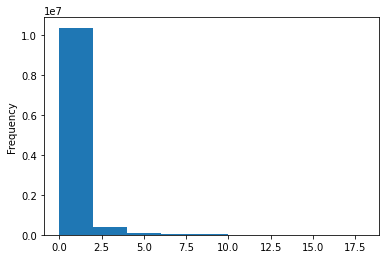

In [20]:
all_data['target'].plot(kind='hist', bins = np.arange(0,20,2))

#### All shops are included in train -> Test has only a subset of these shops

In [21]:
compare_sets(set(all_data['shop_id'].unique()), set(test['shop_id'].unique()))

set 1 size: 60
set 2 size: 42
Union size: 60
set 1 unique elements: 18
set 2 unique elements: 0


### There are new items in test never seen in train 

In [22]:
compare_sets(set(all_data['item_id'].unique()), set(test['item_id'].unique()))

set 1 size: 21807
set 2 size: 5100
Union size: 22170
set 1 unique elements: 17070
set 2 unique elements: 363


In [23]:
items

item_name  item_id  \
0              ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1      !ABBYY FineReader 12 Professional Edition Full...        1   
2          ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3        ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4            ***КОРОБКА (СТЕКЛО)                       D        4   
...                                                  ...      ...   
22165             Ядерный титбит 2 [PC, Цифровая версия]    22165   
22166    Язык запросов 1С:Предприятия  [Цифровая версия]    22166   
22167  Язык запросов 1С:Предприятия 8 (+CD). Хрустале...    22167   
22168                                Яйцо для Little Inu    22168   
22169                      Яйцо дракона (Игра престолов)    22169   

       item_category_id  
0                    40  
1                    76  
2                    40  
3                    40  
4                    40  
...                 ...  
22165                31  
22166                54  
22167                49  
22168                62  
22169                69  

[22170 rows x 3 columns]

In [24]:
all_data['item_category_id'] = all_data['item_id'].map(items.set_index("item_id")['item_category_id'])

### The total quantity of products vary a lot in the training set per month, whereas all the shops in test set have the same qty of products (5100)

In [25]:
### Let's mean encode shop_id and item_id

In [26]:
num = all_data.groupby('item_category_id')['target'].cumsum() - all_data['target']
deno = all_data.groupby('item_id').cumcount() + 1
all_data['category_enc_em'] = num/deno
all_data['category_enc_em'].fillna(all_data['category_enc_em'].mean(), inplace=True)

In [27]:
all_data['category_enc_em']

339319        0.000000
334959        0.000000
334238        0.000000
337534        0.000000
332909        0.000000
              ...     
9385392    1412.407572
9385338    4916.054264
9384465     509.483709
9386635       5.872449
9384827      21.695332
Name: category_enc_em, Length: 10913850, dtype: float64

In [28]:
num = all_data.groupby('item_id')['target'].cumsum() - all_data['target']
deno = all_data.groupby('item_id').cumcount()
all_data['item_enc_em'] = num/deno
all_data['item_enc_em'].fillna(all_data['item_enc_em'].mean(), inplace=True)

In [29]:
num = all_data.groupby('shop_id')['target'].cumsum() - all_data['target']
deno = all_data.groupby('shop_id').cumcount()
all_data['shop_enc_em'] = num/deno
all_data['shop_enc_em'].fillna(all_data['shop_enc_em'].mean(), inplace=True)

In [30]:
num = all_data.groupby(['item_id','shop_id'])['target'].cumsum() - all_data['target']
deno = all_data.groupby(['item_id','shop_id']).cumcount()
all_data['item_shop_enc_em'] = num/deno
all_data['item_shop_enc_em'].fillna(all_data['item_shop_enc_em'].mean(), inplace=True)

In [31]:
all_data.corr()['target']

shop_id             0.009222
item_id            -0.014021
date_block_num     -0.002233
target              1.000000
item_category_id   -0.028386
category_enc_em     0.012220
item_enc_em         0.502536
shop_enc_em         0.071617
item_shop_enc_em    0.583524
Name: target, dtype: float64

In [32]:
features = ['item_enc_em','shop_enc_em','item_shop_enc_em', 'date_block_num']

In [32]:
y = all_data['target']
X = all_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [34]:
xgb_reg = xgb.XGBRegressor(max_depth=3, n_estimators=100, n_jobs=2,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05, verbosity = 1)

In [36]:
xgb_reg.fit(X_train, y_train)

[03:00:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "objectvie" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1,
             objectvie='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=1)

In [37]:
mean_squared_error(xgb_reg.predict(X_train), y_train)

9.860163754854613

In [45]:
mean_squared_error(xgb_reg.predict(X_test), y_test)

12.254020379344599

#### category_item encoding doesn't help -> How to further explore?

#### Basemodel -> Test MSE = 12.25

#### Add more features

In [33]:
sales_shifted_1 = all_data[['shop_id','item_id','date_block_num','target']].copy()
sales_shifted_1['date_block_num'] = sales_shifted_1['date_block_num'] - 1
sales_shifted_1 = sales_shifted_1.rename(columns={"target":"target-1"})

sales_shifted_13 = all_data[['shop_id','item_id','date_block_num','target']].copy()
sales_shifted_13['date_block_num'] = sales_shifted_13['date_block_num'] - 13
sales_shifted_13 = sales_shifted_13.rename(columns={"target":"target-13"})

In [34]:
all_data = all_data.merge(sales_shifted_1, how = 'left', on = ['shop_id','item_id','date_block_num'])

In [35]:
all_data['target-1'].isnull().mean()

0.22686870352808589

In [36]:
all_data = all_data.merge(sales_shifted_13, how = 'left', on = ['shop_id','item_id','date_block_num'])

In [37]:
all_data['target-13'].isnull().mean()

0.7539932287872749

In [38]:
all_data[['target-1','target-13']] = all_data[['target-1','target-13']].fillna(-999)

In [41]:
features = ['item_enc_em','shop_enc_em','item_shop_enc_em', 'date_block_num', 'target-1', 'target-13']
y = all_data['target']
X = all_data[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [70]:
xgb_reg.fit(X_train, y_train)

[23:59:32] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "objectvie" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=2, num_parallel_tree=1,
             objectvie='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=1)

In [71]:
mean_squared_error(xgb_reg.predict(X_train), y_train)

7.438418761497941

In [72]:
mean_squared_error(xgb_reg.predict(X_test), y_test)

9.336288734495513

- Average price of product in a shop in the previous month
- Average price of a product in all shops in the last month
- Ratio of the above two

- 
- 

- Last month total sales / last 12 month total sales

- Maximum disccount within a month
- Last month price difference


In [39]:
price_per_shop = sales_train.groupby(['date_block_num','item_id', 'shop_id'])['item_price'].agg(['min','max','mean']).reset_index(level = ['shop_id'])
price_per_shop = price_per_shop.rename(columns={"min":"min_per_shop", "max" : "max_per_shop", "mean": "mean_per_shop"})

In [40]:
prices_per_item = sales_train.groupby(['date_block_num','item_id'])['item_price'].agg(['min','max','mean'])
prices_per_item = prices_per_item.rename(columns={"min":"min_per_item", "max" : "max_per_item", "mean": "mean_per_item"} )

In [41]:
price_df = price_per_shop.merge(prices_per_item, how = 'left', left_index=True, right_index=True).reset_index()

In [42]:
price_df['date_block_num_-1'] = price_df['date_block_num']-1

In [43]:
price_df['mean_mean_item_discount'] = ( price_df['mean_per_shop'] / price_df['mean_per_item']) - 1

In [44]:
price_df['mean_min_item_discount'] = ( price_df['mean_per_shop'] / price_df['min_per_item']) - 1

In [45]:
price_df['mean_max_item_discount'] = ( price_df['mean_per_shop'] / price_df['max_per_item']) - 1

In [46]:
all_data = all_data.merge(price_df.drop(columns = ['date_block_num']), 
               how = 'left',
               left_on = ['shop_id', 'item_id', 'date_block_num'],
               right_on = ['shop_id', 'item_id', 'date_block_num_-1'])

In [47]:
all_data = all_data.fillna(-999)

In [48]:
all_data

shop_id  item_id  date_block_num  target  item_category_id  \
0               0       19               0     0.0                40   
1               0       27               0     0.0                19   
2               0       28               0     0.0                30   
3               0       29               0     0.0                23   
4               0       32               0     6.0                40   
...           ...      ...             ...     ...               ...   
10913845       59    22162              33     0.0                40   
10913846       59    22163              33     0.0                40   
10913847       59    22164              33     0.0                37   
10913848       59    22166              33     0.0                54   
10913849       59    22167              33     0.0                49   

          category_enc_em  item_enc_em  shop_enc_em  item_shop_enc_em  \
0                0.000000     0.522174     0.337131          0.533574   
1                0.000000     0.522174     0.000000          0.533574   
2                0.000000     0.522174     0.000000          0.533574   
3                0.000000     0.522174     0.000000          0.533574   
4                0.000000     0.522174     0.000000          0.533574   
...                   ...          ...          ...               ...   
10913845      1412.407572     1.560268     0.209455          1.777778   
10913846      4916.054264     0.585938     0.209454          0.000000   
10913847       509.483709     1.238693     0.209453          0.750000   
10913848         5.872449     0.296170     0.209452          0.000000   
10913849        21.695332     1.081967     0.209451          0.160000   

          target-1  ...  min_per_shop  max_per_shop  mean_per_shop  \
0           -999.0  ...        -999.0        -999.0         -999.0   
1              0.0  ...        -999.0        -999.0         -999.0   
2              0.0  ...        -999.0        -999.0         -999.0   
3           -999.0  ...        -999.0        -999.0         -999.0   
4             10.0  ...         221.0         221.0          221.0   
...            ...  ...           ...           ...            ...   
10913845    -999.0  ...        -999.0        -999.0         -999.0   
10913846    -999.0  ...        -999.0        -999.0         -999.0   
10913847    -999.0  ...        -999.0        -999.0         -999.0   
10913848    -999.0  ...        -999.0        -999.0         -999.0   
10913849    -999.0  ...        -999.0        -999.0         -999.0   

          min_per_item  max_per_item  mean_per_item  date_block_num_-1  \
0               -999.0        -999.0     -999.00000             -999.0   
1               -999.0        -999.0     -999.00000             -999.0   
2               -999.0        -999.0     -999.00000             -999.0   
3               -999.0        -999.0     -999.00000             -999.0   
4                221.0         349.0      337.77193                0.0   
...                ...           ...            ...                ...   
10913845        -999.0        -999.0     -999.00000             -999.0   
10913846        -999.0        -999.0     -999.00000             -999.0   
10913847        -999.0        -999.0     -999.00000             -999.0   
10913848        -999.0        -999.0     -999.00000             -999.0   
10913849        -999.0        -999.0     -999.00000             -999.0   

          mean_mean_item_discount  mean_min_item_discount  \
0                     -999.000000                  -999.0   
1                     -999.000000                  -999.0   
2                     -999.000000                  -999.0   
3                     -999.000000                  -999.0   
4                       -0.345712                     0.0   
...                           ...                     ...   
10913845              -999.000000                  -999.0   
10913846              -999.000000                 

In [56]:
features = ['item_enc_em','shop_enc_em','item_shop_enc_em', 'date_block_num', 'target-1', 'target-13', 'mean_mean_item_discount','mean_min_item_discount', 'mean_max_item_discount']
y = all_data['target']
X = all_data[features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [57]:
xgb_reg = xgb.XGBRegressor(max_depth=6, n_estimators=100, n_jobs=8,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05, verbosity = 1)

xgb_reg.fit(X_train, y_train)

[20:37:36] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "objectvie" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objectvie='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=1)

In [58]:
mean_squared_error(xgb_reg.predict(X_train), y_train)

5.5005509070620136

In [59]:
mean_squared_error(xgb_reg.predict(X_test), y_test)

7.338816306639139

### Very small improvement

In [49]:
all_data['item_category_id'].nunique()

84

In [50]:
all_data['item_id'].nunique()

21807

In [49]:
sales_train['revenue'] = sales_train['item_price'] * sales_train['item_cnt_day']

In [50]:
total_rev_shop = sales_train.groupby(['date_block_num','shop_id'])['revenue'].sum().reset_index().copy()
total_rev_shop = total_rev_shop.rename(columns = {'revenue' : 'revenue_shop'})

In [51]:
total_rev_shop['date_block_num_-1'] = total_rev_shop['date_block_num'] - 1
total_rev_shop['date_block_num_-13'] = total_rev_shop['date_block_num'] - 13

In [52]:
total_rev_shop_1 = total_rev_shop.set_index(["date_block_num_-1", "shop_id"])['revenue_shop'].reset_index().rename(columns={"revenue_shop":"revenue_shop_-1"})
total_rev_shop_13 = total_rev_shop.set_index(["date_block_num_-13","shop_id"])['revenue_shop'].reset_index().rename(columns={"revenue_shop":"revenue_shop_-13"})

In [53]:
total_rev_item = sales_train.groupby(['date_block_num','item_id'])['revenue'].sum().reset_index().copy()
total_rev_item = total_rev_item.rename(columns={"revenue":"revenue_item"})

In [54]:
total_rev_item['date_block_num_-1'] = total_rev_item['date_block_num'] - 1
total_rev_item['date_block_num_-13'] = total_rev_item['date_block_num'] - 13

In [55]:
total_rev_item_1 = total_rev_item.set_index(["date_block_num_-1","item_id"])['revenue_item'].reset_index().rename(columns={"revenue_item":"revenue_item_-1"})
total_rev_item_1 = total_rev_item_1.fillna(0) + 1
total_rev_item_13 = total_rev_item.set_index(["date_block_num_-13","item_id"])['revenue_item'].reset_index().rename(columns={"revenue_item":"revenue_item_-13"})
total_rev_item_13 = total_rev_item_13.fillna(0) + 1

In [56]:
total_rev_shop_item = sales_train.groupby(['date_block_num','shop_id','item_id'])['revenue'].sum().reset_index().copy()
total_rev_shop_item = total_rev_shop_item.rename(columns={"revenue":"revenue_shop_item"})

In [57]:
total_rev_shop_item['date_block_num_-1'] = total_rev_shop_item['date_block_num'] - 1
total_rev_shop_item['date_block_num_-13'] = total_rev_shop_item['date_block_num'] - 13

In [58]:
total_rev_shop_item_1 = 1 + total_rev_shop_item.set_index(["date_block_num_-1","shop_id","item_id"])['revenue_shop_item'].reset_index().rename(columns={"revenue_shop_item":"revenue_shop_item-1"})
total_rev_shop_item_13 = 1 + total_rev_shop_item.set_index(["date_block_num_-13","shop_id","item_id"])['revenue_shop_item'].reset_index().rename(columns={"revenue_shop_item":"revenue_shop_item-13"})

In [59]:
sales_train['item_category_id'] = sales_train['item_id'].map(items.set_index("item_id")['item_category_id'])

In [60]:
total_rev_category = sales_train.groupby(['date_block_num','item_category_id'])['revenue'].sum().reset_index().copy()
total_rev_category = total_rev_category.rename(columns={"revenue":"revenue_category"})

In [61]:
total_rev_category['date_block_num_-1'] = total_rev_category['date_block_num'] - 1
total_rev_category['date_block_num_-13'] = total_rev_category['date_block_num'] - 13

In [62]:
total_rev_category_1 = 1 + total_rev_category.set_index(["date_block_num_-1","item_category_id"])['revenue_category'].reset_index().rename(columns={"revenue_category":"revenue_category-1"})
total_rev_category_13 = 1 + total_rev_category.set_index(["date_block_num_-13","item_category_id"])['revenue_category'].reset_index().rename(columns={"revenue_category":"revenue_category-13"})

In [63]:
all_data = all_data.merge(total_rev_shop_1, how = 'left', left_on = ['date_block_num','shop_id'], right_on=['date_block_num_-1','shop_id'])
all_data = all_data.merge(total_rev_shop_13, how = 'left', left_on = ['date_block_num','shop_id'], right_on=['date_block_num_-13','shop_id'])

In [64]:
all_data['rev_shop_ratio'] = all_data['revenue_shop_-1']/all_data['revenue_shop_-13']

In [65]:
all_data = all_data.merge(total_rev_item_1, how = 'left', left_on=['date_block_num', 'item_id'],right_on = ["date_block_num_-1","item_id"])
all_data = all_data.merge(total_rev_item_13, how = 'left', left_on = ['date_block_num','item_id'], right_on=['date_block_num_-13','item_id'])

In [66]:
all_data['rev_item_ratio'] = all_data['revenue_item_-1']/all_data['revenue_item_-13']

In [67]:
all_data['rev_item_ratio'].max()

119347.85

In [68]:
all_data = all_data.merge(total_rev_shop_item_1, how = 'left', left_on=["date_block_num","shop_id","item_id"],right_on = ["date_block_num_-1","shop_id","item_id"])
all_data = all_data.merge(total_rev_shop_item_13, how = 'left', left_on=["date_block_num","shop_id","item_id"],right_on = ["date_block_num_-13","shop_id","item_id"])

/Users/menoci/.pyenv/versions/3.8.11/lib/python3.8/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'date_block_num_-1_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [69]:
all_data['rev_shop_item_ratio'] = all_data['revenue_shop_item-1']/all_data['revenue_shop_item-13']

In [70]:
all_data = all_data.merge(total_rev_category_1, how = 'left', left_on=["date_block_num","item_category_id"],right_on = ["date_block_num_-1","item_category_id"])
all_data = all_data.merge(total_rev_category_13, how = 'left', left_on=["date_block_num","item_category_id"],right_on = ["date_block_num_-13","item_category_id"])

/Users/menoci/.pyenv/versions/3.8.11/lib/python3.8/site-packages/pandas/core/frame.py:9191: FutureWarning: Passing 'suffixes' which cause duplicate columns {'date_block_num_-13_x'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [71]:
all_data['rev_category_ratio'] = all_data['revenue_category-1']/all_data['revenue_category-13']

In [72]:
features = [
 'category_enc_em',
 'item_enc_em',
 'shop_enc_em',
 'item_shop_enc_em',
 'target-1',
 'target-13',
 'mean_mean_item_discount',
 'mean_min_item_discount',
 'mean_max_item_discount',
 'rev_shop_ratio',
 'rev_item_ratio',
 'rev_shop_item_ratio',
 'rev_category_ratio']

y = all_data['target']
X = all_data[features]

X = X.fillna(-999)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [73]:
X_train.max()

category_enc_em            6.265650e+05
item_enc_em                1.996842e+02
shop_enc_em                9.200000e+00
item_shop_enc_em           1.242000e+03
target-1                   2.253000e+03
target-13                  2.253000e+03
mean_mean_item_discount    2.580576e+01
mean_min_item_discount     5.197000e+03
mean_max_item_discount     2.220446e-16
rev_shop_ratio             5.683179e+00
rev_item_ratio             1.193479e+05
rev_shop_item_ratio        2.473300e+04
rev_category_ratio         1.397786e+03
dtype: float64

In [74]:
xgb_reg = xgb.XGBRegressor(max_depth=6, n_estimators=100, n_jobs=8,
                           objectvie='reg:squarederror', booster='gbtree',
                           random_state=42, learning_rate=0.05, verbosity = 1)

xgb_reg.fit(X_train, y_train)

[21:27:39] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "objectvie" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objectvie='reg:squarederror', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='approx', validate_parameters=1, verbosity=1)

In [75]:
mean_squared_error(xgb_reg.predict(X_train), y_train)

4.921989960084637

In [80]:
mean_squared_error(xgb_reg.predict(X_test), y_test)

6.6933582504241755

In [78]:
y_test.describe()

count    2.728463e+06
mean     3.383289e-01
std      3.680209e+00
min     -5.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.644000e+03
Name: target, dtype: float64

<AxesSubplot:xlabel='date_block_num'>

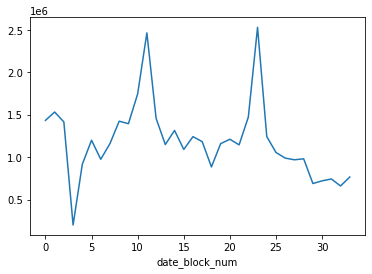

In [83]:
total_rev[total_rev['shop_id'] == 4].set_index('date_block_num')['revenue'].plot()

In [192]:
item_categories.head()

item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1
2         Аксессуары - PS3                 2
3         Аксессуары - PS4                 3
4         Аксессуары - PSP                 4

In [182]:
xgb_reg.score(X_train, y_train)

0.3492571986132471

In [183]:
xgb_reg.score(X_test, y_test)

0.3338165417624763